In [8]:
# Cell A: set your image dataset root
import os, platform
import pandas as pd
from pathlib import Path

DATA_ROOT = r"E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images"

# keep earlier knobs
IMG_SIZE = 224
BATCH_SIZE = 16
NUM_WORKERS = 0 if platform.system().lower().startswith("win") else 2

CLASSES_CANON = {"BF","BFI","GF","GFI","N","NI","TF"}  # expected labels
print("DATA_ROOT:", DATA_ROOT)


DATA_ROOT: E:\1 Paper MCT\Cutting Tool Paper\Dataset\cutting tool data\test_data_40_images


In [9]:
# Cell B: scan images and infer labels
from PIL import Image

IMG_EXTS = {".png", ".jpg", ".jpeg", ".bmp", ".webp"}

def scan_image_dataset(root):
    root = Path(root)
    assert root.exists(), f"Path not found: {root}"

    # Case 1: class subfolders exist
    subdirs = [d for d in root.iterdir() if d.is_dir()]
    records = []

    if subdirs:
        for d in sorted(subdirs):
            label = d.name
            for p in d.rglob("*"):
                if p.suffix.lower() in IMG_EXTS:
                    records.append({"path": str(p), "label": label})
    else:
        # Case 2: flat files; infer label from filename prefix before "_"
        for p in root.rglob("*"):
            if p.suffix.lower() in IMG_EXTS:
                name = p.stem
                # try BF_001.png → "BF"
                prefix = name.split("_")[0]
                label = prefix
                records.append({"path": str(p), "label": label})

    df = pd.DataFrame(records)
    if len(df) == 0:
        print("No image files found. Make sure your folder contains .png/.jpg/etc.")
        return [], df

    # Canonicalize: only keep expected classes if present
    found_labels = sorted(df["label"].unique().tolist())
    print("Found labels:", found_labels)
    return found_labels, df

CLASSES, FILES_DF = scan_image_dataset(DATA_ROOT)
print("Total images:", len(FILES_DF))
if len(FILES_DF):
    display(FILES_DF.groupby("label")["path"].count())


Found labels: ['BF', 'BFI', 'GF', 'GFI', 'N', 'NI', 'TF']
Total images: 280


label
BF     40
BFI    40
GF     40
GFI    40
N      40
NI     40
TF     40
Name: path, dtype: int64

In [10]:
# Cell C: dataset & dataloaders for images
import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as T

label_to_id = {c: i for i, c in enumerate(sorted(CLASSES))}
id_to_label = {i: c for c, i in label_to_id.items()}

basic_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.ToTensor(),
    # ImageNet normalization (for pretrained ResNet backbones)
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

aug_tfms = T.Compose([
    T.Resize((IMG_SIZE, IMG_SIZE), antialias=True),
    T.RandomApply([T.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2)], p=0.3),
    T.RandomHorizontalFlip(p=0.5),
    T.RandomAffine(degrees=10, translate=(0.05, 0.05), scale=(0.95, 1.05)),
    T.ToTensor(),
    T.Normalize(mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225]),
])

class ImageAEDataset(Dataset):
    def __init__(self, df: pd.DataFrame, augment=False):
        self.df = df.reset_index(drop=True)
        self.tfms = aug_tfms if augment else basic_tfms

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img = Image.open(row["path"]).convert("RGB")
        x = self.tfms(img)              # [3, 224, 224]
        y = label_to_id[row["label"]]   # int label
        return x, y, row["path"]


In [11]:
# Cell D: split and create dataloaders
from sklearn.model_selection import train_test_split

assert len(FILES_DF) > 0, "No images found—check the path or file extensions."

train_df, val_df = train_test_split(
    FILES_DF, test_size=0.2, stratify=FILES_DF["label"], random_state=42
)

train_ds = ImageAEDataset(train_df, augment=True)
val_ds   = ImageAEDataset(val_df, augment=False)

train_dl = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS)
val_dl   = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

len(train_ds), len(val_ds)


(224, 56)

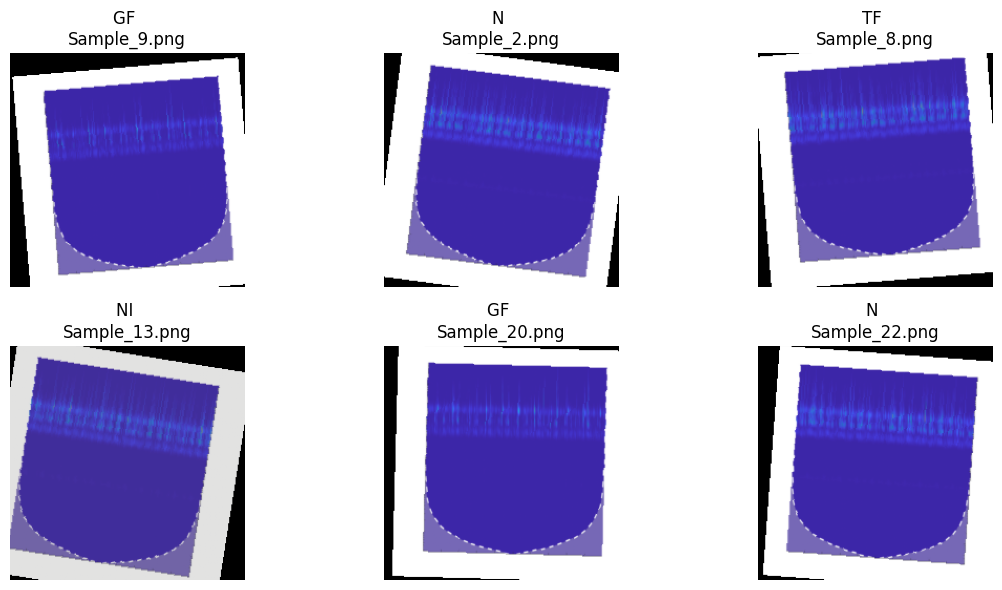

In [12]:
# Cell E: visualize a few training images with labels
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F

def denorm(img_t):
    # undo ImageNet normalization for display
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3,1,1)
    std  = torch.tensor([0.229, 0.224, 0.225]).view(3,1,1)
    return img_t * std + mean

imgs, ys, paths = next(iter(train_dl))
n = min(6, len(imgs))

plt.figure(figsize=(12,6))
for i in range(n):
    plt.subplot(2, (n+1)//2, i+1)
    plt.imshow(denorm(imgs[i]).permute(1,2,0).clip(0,1))
    plt.title(f"{id_to_label[int(ys[i])]} \n{Path(paths[i]).name}")
    plt.axis('off')
plt.tight_layout()
plt.show()


In [13]:
# Cell F: Backbone + attention → 512-D embeddings
import torch
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F

class SpatialAttention(nn.Module):
    """CBAM-like spatial attention: uses avg+max across channels → 7x7 conv → sigmoid."""
    def __init__(self, kernel_size=7):
        super().__init__()
        padding = (kernel_size - 1) // 2
        self.conv = nn.Conv2d(2, 1, kernel_size, padding=padding, bias=False)

    def forward(self, x):
        avg_out = torch.mean(x, dim=1, keepdim=True)
        max_out, _ = torch.max(x, dim=1, keepdim=True)
        attn = torch.sigmoid(self.conv(torch.cat([avg_out, max_out], dim=1)))
        return x * attn

class ResNet50Attention(nn.Module):
    def __init__(self, embed_dim=512, pretrained=True):
        super().__init__()
        m = models.resnet50(weights=models.ResNet50_Weights.IMAGENET1K_V2 if pretrained else None)
        # Keep everything up to layer4 (exclude avgpool & fc)
        self.stem = nn.Sequential(
            m.conv1, m.bn1, m.relu, m.maxpool,
            m.layer1, m.layer2, m.layer3, m.layer4
        )
        self.attn = SpatialAttention(kernel_size=7)
        self.pool = nn.AdaptiveAvgPool2d((1,1))
        self.proj = nn.Sequential(
            nn.Flatten(),
            nn.Linear(2048, embed_dim, bias=False),
            nn.BatchNorm1d(embed_dim)
        )

    def forward(self, x):
        f = self.stem(x)          # [B, 2048, H, W]
        f = self.attn(f)          # spatial attention
        f = self.pool(f)          # [B, 2048, 1, 1]
        z = self.proj(f)          # [B, 512]
        z = F.normalize(z, dim=1) # L2-normalize embeddings
        return z

EMBED_DIM = 512
model = ResNet50Attention(embed_dim=EMBED_DIM, pretrained=True)
model.eval(); model.to(DEVICE)
sum(p.numel() for p in model.parameters())/1e6, DEVICE


(24.55773, 'cpu')

In [14]:
# Cell G: helper to embed a dataset
@torch.no_grad()
def embed_loader(model, loader, device=DEVICE):
    zs, ys, paths = [], [], []
    for x, y, p in loader:
        x = x.to(device, non_blocking=True)
        z = model(x)             # [B, 512]
        zs.append(z.cpu())
        ys.append(y.cpu())
        paths += list(p)
    Z = torch.cat(zs, dim=0)     # [N, 512]
    Y = torch.cat(ys, dim=0)     # [N]
    return Z, Y, paths

# quick check on a small batch
xb, yb, _ = next(iter(train_dl))
with torch.no_grad():
    zb = model(xb.to(DEVICE))
zb.shape


torch.Size([16, 512])

In [15]:
# Cell H: make a K-shot episode and embed it
from sklearn.utils import check_random_state

def make_support_df(train_df, k_shot=5, seed=42):
    rng = check_random_state(seed)
    parts = []
    for c, g in train_df.groupby("label"):
        g = g.sample(frac=1.0, random_state=rng.randint(0, 10_000))
        take = min(k_shot, len(g))
        parts.append(g.iloc[:take])
    return pd.concat(parts).reset_index(drop=True)

def make_episode(k_shot=5):
    support_df = make_support_df(train_df, k_shot=k_shot, seed=42)
    query_df   = val_df.copy().reset_index(drop=True)

    support_ds = ImageAEDataset(support_df, augment=False)
    query_ds   = ImageAEDataset(query_df, augment=False)

    support_dl = DataLoader(support_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)
    query_dl   = DataLoader(query_ds,   batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS)

    Zs, Ys, Ps = embed_loader(model, support_dl)
    Zq, Yq, Pq = embed_loader(model, query_dl)
    return (support_df, Zs, Ys, Ps), (query_df, Zq, Yq, Pq)

# Build a 5-shot episode
(support_df, Zs, Ys, Ps), (query_df, Zq, Yq, Pq) = make_episode(k_shot=5)
Zs.shape, Zq.shape, len(CLASSES)


(torch.Size([35, 512]), torch.Size([56, 512]), 7)

In [16]:
# Cell I: prototypes and three distance heads
import numpy as np

@torch.no_grad()
def class_prototypes(Zs, Ys, num_classes):
    protos = torch.zeros(num_classes, Zs.size(1))
    for c in range(num_classes):
        m = Ys == c
        if m.any():
            protos[c] = Zs[m].mean(dim=0)
        else:
            protos[c] = 0.0
    protos = F.normalize(protos, dim=1)
    return protos

def predict_euclidean(Zq, protos):
    # nearest prototype by L2
    dists = torch.cdist(Zq, protos, p=2)       # [Nq, C]
    return torch.argmin(dists, dim=1), dists

def predict_cosine(Zq, protos):
    sims = Zq @ protos.t()                     # [Nq, C], since both are normalized
    return torch.argmax(sims, dim=1), sims

def predict_mahalanobis(Zq, Zs, Ys, num_classes, eps=1e-5):
    # shared covariance across all support, per "linear discriminant analysis" style
    mu = class_prototypes(Zs, Ys, num_classes)       # [C, D]
    Zc = []
    for c in range(num_classes):
        m = Ys == c
        if m.any():
            Zc.append((Zs[m] - mu[c]).cpu().numpy())
    Zc = np.concatenate(Zc, axis=0) if len(Zc) else Zs.cpu().numpy()
    Sigma = np.cov(Zc.T)                            # [D, D]
    # regularize
    Sigma += eps*np.eye(Sigma.shape[0])
    iSigma = torch.from_numpy(np.linalg.inv(Sigma)).float()  # [D, D]

    # Mahalanobis distance to each class mean
    diffs = Zq.unsqueeze(1) - mu.unsqueeze(0)       # [Nq, C, D]
    left  = torch.matmul(diffs, iSigma)             # [Nq, C, D]
    d2    = torch.sum(left * diffs, dim=2)          # [Nq, C]
    preds = torch.argmin(d2, dim=1)
    return preds, d2

# Build prototypes & predictions
num_classes = len(label_to_id)
protos = class_prototypes(Zs, Ys, num_classes)
pred_euc, _ = predict_euclidean(Zq, protos)
pred_cos, _ = predict_cosine(Zq, protos)
pred_mah, _ = predict_mahalanobis(Zq, Zs, Ys, num_classes)

pred_euc[:10], pred_cos[:10], pred_mah[:10]


(tensor([2, 6, 6, 6, 1, 1, 2, 6, 3, 1]),
 tensor([2, 6, 6, 6, 1, 1, 2, 6, 3, 1]),
 tensor([2, 6, 5, 6, 1, 1, 2, 6, 3, 1]))

Euclidean accuracy: 0.8929


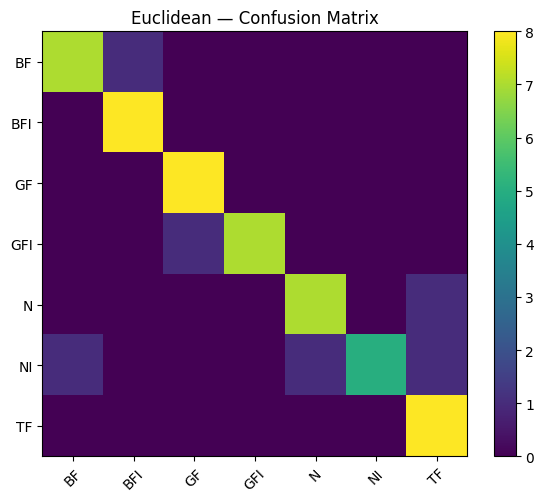

Cosine accuracy: 0.8929


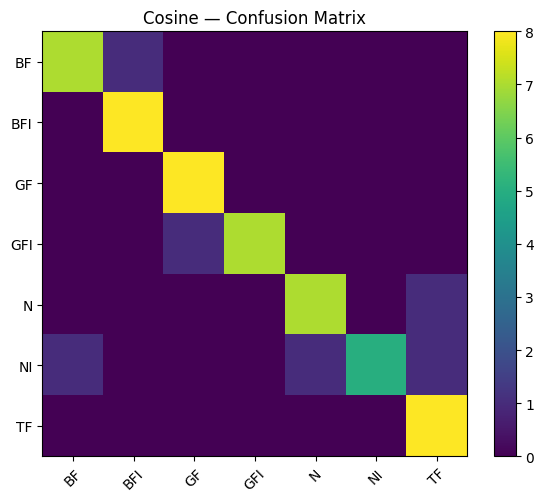

Mahalanobis (shared Σ) accuracy: 0.9286


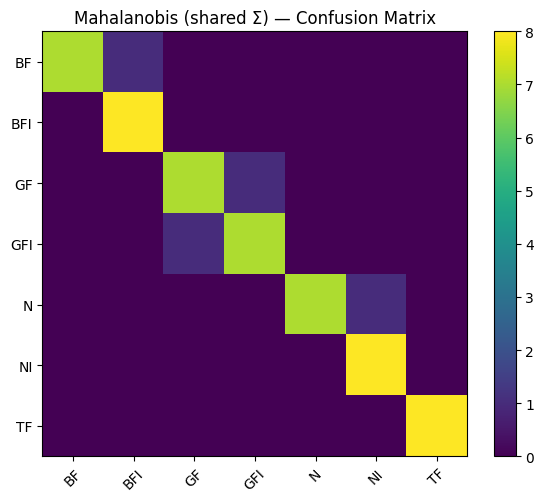

(0.8928571428571429, 0.8928571428571429, 0.9285714285714286)

In [17]:
# Cell J: metrics
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix
import matplotlib.pyplot as plt

def evaluate_preds(y_true, y_pred, title):
    acc = accuracy_score(y_true, y_pred)
    cm  = confusion_matrix(y_true, y_pred, labels=list(range(num_classes)))
    print(f"{title} accuracy: {acc:.4f}")
    plt.figure(figsize=(6,5))
    plt.imshow(cm, interpolation='nearest')
    plt.title(f"{title} — Confusion Matrix")
    plt.colorbar()
    plt.xticks(range(num_classes), [id_to_label[i] for i in range(num_classes)], rotation=45)
    plt.yticks(range(num_classes), [id_to_label[i] for i in range(num_classes)])
    plt.tight_layout()
    plt.show()
    return acc, cm

Ytrue = Yq.numpy()
acc_e, cm_e = evaluate_preds(Ytrue, pred_euc.numpy(), "Euclidean")
acc_c, cm_c = evaluate_preds(Ytrue, pred_cos.numpy(), "Cosine")
acc_m, cm_m = evaluate_preds(Ytrue, pred_mah.numpy(), "Mahalanobis (shared Σ)")

acc_e, acc_c, acc_m
